# Focality Branch
- find a way of simulating focal vs non-focal tasks

In [1]:
from glob import glob as glob
import torch as tr
import numpy as np

from PMmodel import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
seed = 132
tr.manual_seed(seed)
np.random.seed(seed)

# load data

In [3]:
def load_score(fpath,verb=False):
  neps = 1500
  teseqlen = 15
  fpathL = glob('model_data/'+fpath)
  if verb:
    for i in fpathL: print(i)
  nnets = len(fpathL)
  score = -np.ones([nnets,neps,teseqlen])
  for netn,fpath in enumerate(fpathL):
    score[netn] = np.load(fpath)
  return score

og_trials = [4,5]
pm_trials = [6,11]

# train and eval script

In [4]:
## task
nback=2
ntokens_og=3
num_pm_trials=4
edim_og=8
edim_pm=4
focal=0
pm_weight = 2
trseqlen = 25

## network
indim = edim_og+edim_pm
stsize = 30
batch=1
outdim=3
EM=True

In [6]:
# model and task
net = PMNet(indim,stsize,outdim,EM)
task = NBackPMTask(nback,ntokens_og,num_pm_trials,edim_og,edim_pm,focal,seed=132)
net

PMNet(
  (ff_in): Linear(in_features=8, out_features=15, bias=True)
  (relu): ReLU()
  (cell): LSTMCell(15, 15)
  (ff_out): Linear(in_features=15, out_features=3, bias=True)
  (rgate): Linear(in_features=15, out_features=15, bias=True)
  (sigm): Tanh()
)

### train

In [7]:
def train(net,task,nepochs=1000,thresh=.99,pm_weight=1):
  weight=tr.FloatTensor([1,1,pm_weight])
  print(weight)
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.005)
  L = -np.ones([nepochs])
  A = -np.ones([nepochs])
  E = -np.ones([nepochs])
  acc,nembeds = 0,0
  for ep in range(nepochs):
    if ep%(nepochs/5)==0:
      print(ep/nepochs)
    # randomize emat
    if acc>thresh:
      task.sample_emat()
      nembeds+=1
    # generate data
    x_seq,y_seq = task.gen_seq(trseqlen)
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    # collect loss through time
    loss,acc = 0,0
    for yh,yt in zip(yhat,ytarget):
      loss += weight[yt]*lossop(yh,yt)
      acc += yt==tr.argmax(tr.softmax(yh,1))
    acc = acc.numpy()/len(yhat)
    # bp and update
    optiop.zero_grad()
    loss.backward()
    optiop.step()
    epoch_loss = loss.item()
    L[ep] = epoch_loss
    A[ep] = acc
    E[ep] = nembeds
  return net

def eval_(net,task,neps=1500,teseqlen=15,verb=False):
  score = -np.ones([neps,teseqlen])
  rgate = -np.ones([neps,teseqlen,net.stsize])
  for ep in range(neps):
    # embedding matrix
    task.sample_emat()
    # generate data
    x_seq,y_seq = task.gen_seq(teseqlen,pm_trial_position=[5,9])
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    if verb:
      print(net.sim)
      print(net.sim[(6,11),:])
      print(net.sim[(1,2,3,4),:])
      print(net.rgate_act.shape)
    ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
    score[ep] = ep_score 
    rgate[ep] = net.rgate_act.detach().numpy()
  return score,rgate


In [8]:
_,rgate = eval_(net,task,neps=1)

In [9]:
net = train(net,task,nepochs=50000,pm_weight=1)

tensor([1., 1., 1.])
0.0
0.2
0.4
0.6
0.8


In [10]:
score,rgate = eval_(net,task,neps=500)

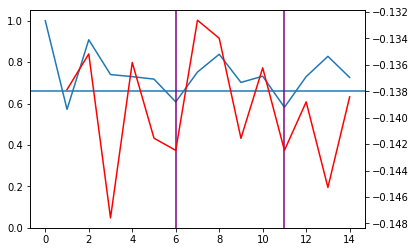

In [11]:
ax = plt.gca()

ax.set_ylim(0,1.05)
ax.plot(score.mean(0))
ax.axhline(.66)
ax2 = plt.twinx()
ax2.plot(np.arange(1,15),rgate[:,1:].mean((0,2)),c='r')

for t in [6,11]:
  ax.axvline(t,c='purple')
